In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.xception import Xception

In [2]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [3]:
!head 'food-101/food-101/meta/train.txt'

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [4]:
train_df = pd.read_csv('food-101/food-101/meta/train.txt', header = None, names=['path'])
test_df = pd.read_csv('food-101/food-101/meta/test.txt', header = None, names=['path'])
len(train_df)

75750

In [5]:
def spliter(data, class_or_id='id'):
    if class_or_id.upper() == 'CLASS':
        output = data.split('/')[0]
        
    else:
        output = data.split('/')[-1]
    return output

In [6]:
train_df['label'] = train_df['path'].map(lambda x: spliter(data = x, class_or_id = 'Class')) 
train_df['idx'] = train_df['path'].map(lambda x: spliter(x)) 
test_df['label'] = test_df['path'].map(lambda x: spliter(x, 'class')) 
test_df['idx'] = test_df['path'].map(lambda x: spliter(x)) 

In [7]:
food_25 = train_df['label'].unique()[:20]
print(food_25)

['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheesecake' 'cheese_plate' 'chicken_curry'
 'chicken_quesadilla']


In [8]:
list_ = []
for f in food_25:
    list_.append(f.upper())
food_21 = [food.upper() for food in food_25]

In [9]:
def prepare_data(label):
    if label.upper() in food_25:
        return label
    else:
        return 'others'

In [10]:
train_df['label'] = train_df['label'].map(lambda x: prepare_data(x))
test_df['label'] = test_df['label'].map(lambda x: prepare_data(x))
print(train_df['label'].unique())

['others']


In [11]:
def Adding_Path(path):
    return 'food-101/food-101/images/'+path+'.jpg'
train_df['path'] = train_df[['path']].apply(Adding_Path, axis=1)
test_df['path'] = test_df[['path']].apply(Adding_Path, axis=1)

In [12]:
test_images = plt.imread(test_df['path'].iloc[118])
test_images = test_images/200.
test_images.shape

(512, 512, 3)

(512, 512, 3)

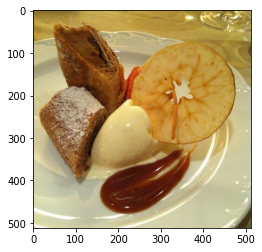

In [13]:
train_images = plt.imread(train_df['path'].iloc[105])
plt.imshow(train_images)
train_images.shape

In [14]:
datagen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
#test_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = datagen.flow_from_dataframe(dataframe = test_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=32,shuffle=False)

train_gen = datagen.flow_from_dataframe(dataframe = train_df, directory=None, x_col='path', y_col='label',
    weight_col=None, target_size=(256, 256), color_mode='rgb', 
    classes=None, class_mode='categorical', batch_size=32, shuffle=True)

Found 25250 validated image filenames belonging to 1 classes.
Found 75750 validated image filenames belonging to 1 classes.


In [15]:
inception = Xception(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

83697664/83683744 [==============================] - 1s 0us/step


In [16]:
history = model.fit(train_gen,
                    steps_per_epoch = len(train_gen) // 3,
                    epochs=2,
                    verbose=1)

Epoch 1/2
789/789 [==============================] - 609s 757ms/step - loss: 23918.9121 - accuracy: 0.0013
Epoch 2/2
789/789 [==============================] - 555s 702ms/step - loss: 216806.0625 - accuracy: 2.7725e-04


In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


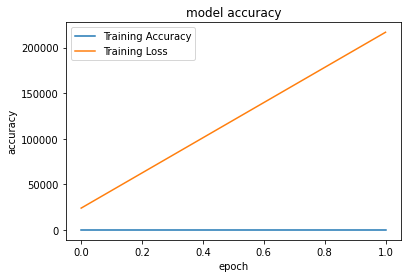

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Training Loss'], loc='upper left')
plt.show()

In [19]:
results = model.evaluate(test_gen, batch_size=3)
print(results)
#import sys
#sys.getsizeof(test_gen)

790/790 [==============================] - 592s 749ms/step - loss: 317391.6250 - accuracy: 0.0000e+00
[317391.625, 0.0]
